# Validation Notebook

Set up the parameters in cell below, then run the entire notebook to get a quick summary of the results from the simulation and a framework for further analysis.

## Imports

In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import pathlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [38]:
RUN_BUNDLE_NAME = "2001-30-CA-M3-100-110"  # REPLACE WITH YOUR DESIRED SIMULATION RUN
PATH_OUTPUT = "output"  # Replace with the path to the output folder
PROVINCE = "CA"
N_BIRTHS = 10
STARTING_YEAR = 2024
PROJECTION_SCENARIO = "LG"

In [185]:
MALE_COLOUR = "#09bfc4"
FEMALE_COLOUR = "#f86d63"
# CSV_INFO follows
# csv_name : ()
CSV_INFO = {
    'alive': {
        'column_name': 'n_alive',
        'column_text': 'Population',
        "title": f"Population in {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'antibiotic_exposure': {
        'column_name': 'n_antibiotic_exposure',
        'column_text': 'Number of Courses of Antibiotics',
        "title": f"Antibiotic Use\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'asthma_incidence': {
        'column_name': 'n_new_diagnoses',
        'column_text': 'Number of New Asthma Diagnoses',
        "title": f"People with a New Asthma Diagnosis this Year (Incidence)\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'asthma_prevalence': {
        'column_name': 'n_asthma',
        'column_text': 'Number of People with Asthma',
        "title": f"People with a Current Asthma Diagnosis (Prevalence)\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'asthma_status': {
        'column_name': 'status',
        'column_text': 'Number of People with Any Past Asthma Diagnosis',
        "title": f"People with an Asthma Diagnosis during their Lifetime\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'control': {
        'column_name': 'prob',
        'column_text': 'Control probability'
    },
    'cost': {
        'column_name': 'cost',
        'column_text': 'Cost due to Asthma (CAD)',
        "title": f"Economic Cost of Asthma\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'death': {
        'column_name': 'n_deaths',
        'column_text': 'Number of Deaths',
        "title": f"Number of Deaths\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'emigration': {
        'column_name': 'n_emigrants',
        'column_text': 'Number of Emigrants',
        "title": f"Emigration from {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'exacerbation_by_severity': {
        'column_name': 'p_exacerbations',
        'column_text': 'Exacerbation severity level'
    },
    'exacerbation_hospital': {
        'column_name': 'n_hospitalizations',
        'column_text': 'Number of Hospitalizations due to Asthma',
        "title": f"Hospitalizations due to Asthma\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'exacerbation': {
        'column_name': 'n_exacerbations',
        'column_text': 'Number of Asthma Exacerbations (all severities)',
        "title": f"Asthma Exacerbations\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'family_history': {
        'column_name': 'has_family_history',
        'column_text': 'Number of People with a Family History of Asthma',
        "title": f"Family History of Asthma\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'immigration': {
        'column_name': 'n_immigrants',
        'column_text': 'Number of Immigrants',
        "title": f"Immigration to {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
    'utility': {
        'column_name': 'utility',
        'column_text': 'Net Utility due to Asthma',
        "title": f"Utility\nProvince: {PROVINCE}\nInitial Births in {STARTING_YEAR}: {N_BIRTHS}\nProjection Scenario: {PROJECTION_SCENARIO}"
    },
}

## Utility Functions

In [182]:
def plot_simulation_csv(
    run_bundle_name: str,
    path_output: str,
    outcome_matrix_csv_name: str,
    user_linewidth: int = 2
):
    """Plots the simulation results from a CSV file.

    This function reads simulation data from a CSV file and generates a series of plots
    showing the number of alive individuals by age for each year, separated by sex.
    
    Args:
        run_bundle_name:
            The name of the simulation run bundle, which is used to locate the CSV file.
        path_output:
            The path to the output folder containin the simulation run results.
        outcome_matrix_csv_name:
            The suffix name of the CSV file containing the simulation data.
            Must be one of the following:
            - 'alive',
            - 'antibiotic_exposure'
            - 'asthma_incidence_contingency_table'
            - 'asthma_incidence'
            - 'asthma_prevalence_contingency_table'
            - 'asthma_prevalence'
            - 'asthma_status'
            - 'control'
            - 'cost'
            - 'death'
            - 'emigration'
            - 'exacerbation_by_severity'
            - 'exacerbation_hospital'
            - 'family_history'
            - 'immigration'
            - 'utility'
    
        user_linewidth:
            The width of the lines in the plot (default is 2).
        
    Returns:
        This function does not return any value. It displays the plots.
        
    Notes:
        - The CSV file should be located at `output/{run_bundle_name}/{outcome_matrix_csv_name}.csv`.
        - The CSV file should contain columns: "year", "age", and "sex"
        - The function assumes that ``MALE_COLOUR`` and ``FEMALE_COLOUR`` are predefined colors for the plots.
    """
    
    # Read in data from simulation
    csv_file_path = pathlib.Path(path_output, f"{run_bundle_name}/outcome_matrix_{outcome_matrix_csv_name}.csv").resolve()
    df_outcome: pd.DataFrame = pd.read_csv(csv_file_path)

    # Figure Parameters
    years = df_outcome["year"].unique()
    num_cols = min(len(years), 3)
    # Dynamically calculate number of rows based on number of years and number of columns
    num_rows = math.ceil(len(years) / num_cols)

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7 * num_cols, 5 * num_rows))

    for i, year in enumerate(years):
        # Index axis to be in 2D grid of size (num_rows x num_cols) using i
        if num_rows == 1:
            if num_cols == 1:
                ax: plt.Axes = axs
            else:
                ax: plt.Axes = axs[i % num_cols]
        else:
            ax: plt.Axes = axs[i // num_rows][i % num_cols]

        # Filter simulation data by current year
        df_outcome_modified = df_outcome[df_outcome["year"] == year]

        # Filter by males and females
        df_outcome_M = df_outcome_modified[df_outcome_modified["sex"] == "M"]
        df_outcome_F = df_outcome_modified[df_outcome_modified["sex"] == "F"]
        
        # Get name of column to plot
        column_name = CSV_INFO[outcome_matrix_csv_name]['column_name']
        column_text = CSV_INFO[outcome_matrix_csv_name]['column_text']

        ax.plot(df_outcome_M["age"],
                df_outcome_M[column_name],
                color=MALE_COLOUR,
                linewidth=user_linewidth)

        ax.plot(df_outcome_F["age"],
                df_outcome_F[column_name],
                color=FEMALE_COLOUR,
                linewidth=user_linewidth)
        ax.grid()

        # Set axis labels
        ax.set_title(f"{year}", fontsize=12)

    # Get relative path to file to put in title
    title_file = str(csv_file_path.relative_to(pathlib.Path(path_output).resolve()))

    fig.supxlabel("Age (years)")
    fig.supylabel(column_text)
    fig.suptitle(CSV_INFO[outcome_matrix_csv_name]["title"], fontsize=16)
    fig.legend(["male", "female"])
    plt.tight_layout(rect=[0.01, 0, 1, 0.95])
    plt.show()

## Plot Simulation Results

#### outcome_matrix_alive.csv

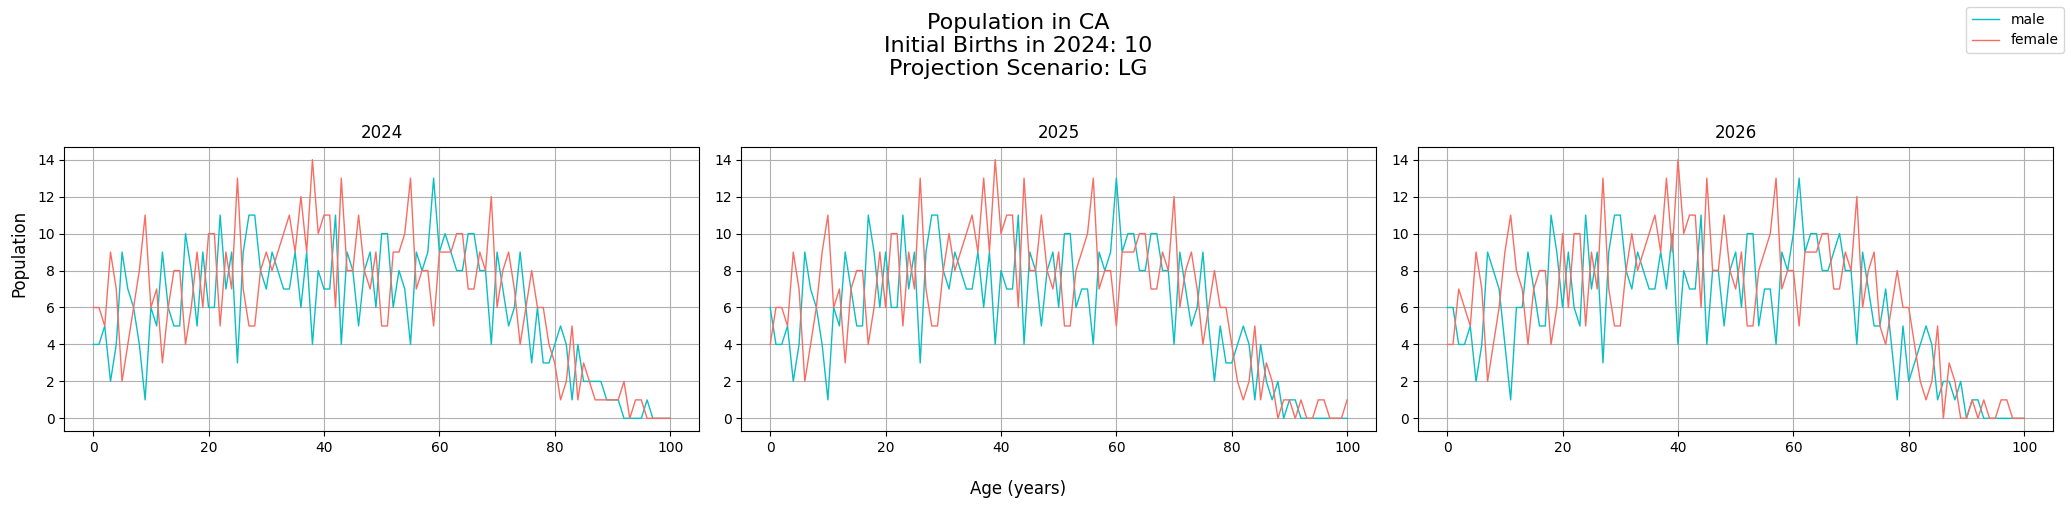

In [183]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'alive', 1)

#### outcome_matrix_antibiotic_exposure.csv

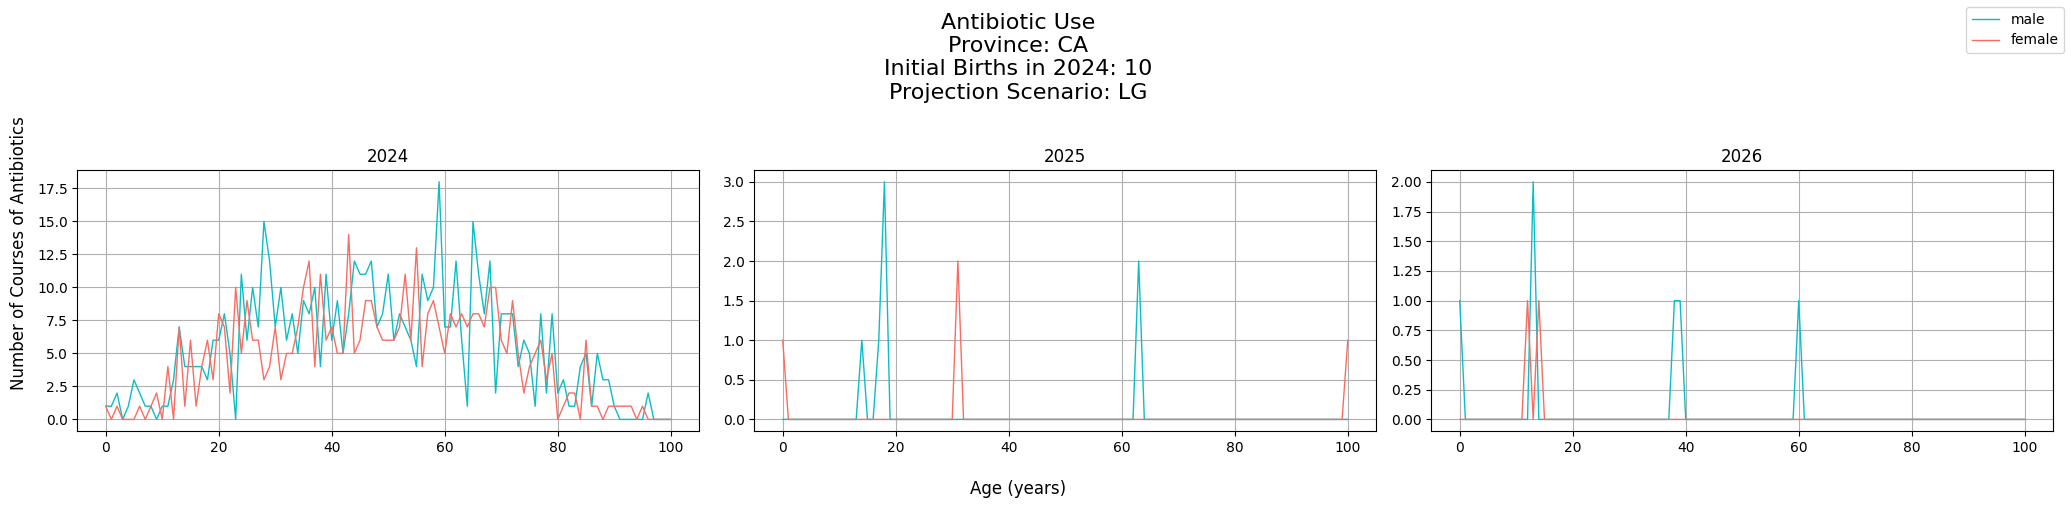

In [186]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'antibiotic_exposure', 1)

#### outcome_matrix_utility.csv

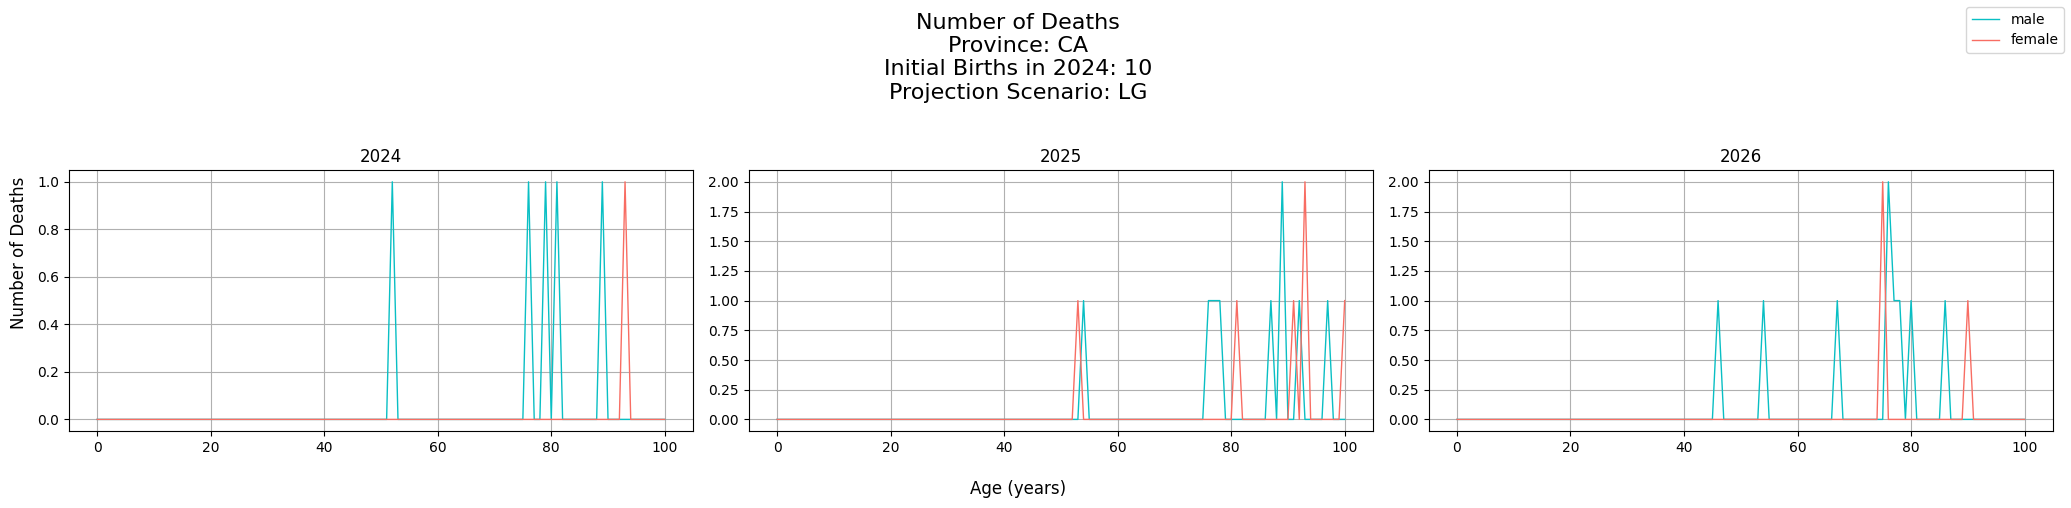

In [187]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'death', 1)

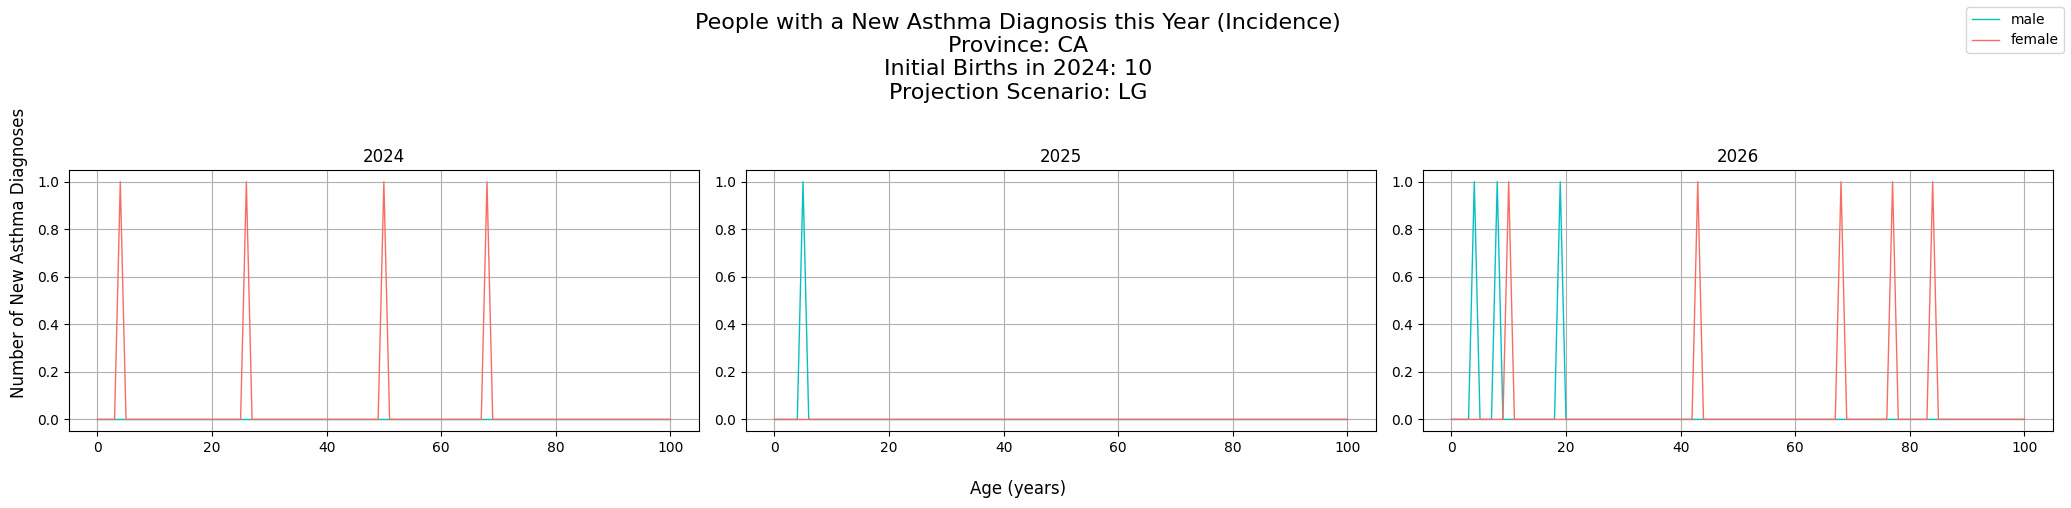

In [188]:
plot_simulation_csv(RUN_BUNDLE_NAME, PATH_OUTPUT, 'asthma_incidence', 1)